This post is the second of a series of tutorials where I illustrate basic fMRI analyses with [pilab](https://github.com/jooh/pilab). Today we will construct a pseudo-distance matrix with cross-validated linear discriminant contrast. In addition to pilab you will need my [figure code](https://github.com/jooh/matlab-plotting) and probably my [general-purpose utility code](https://github.com/jooh/johansmatlab) to get the example below to run. Have fun!

### Building simulated fMRI data
To review, we are going to make up some data to model. If you read [part 1]({pilab_demo1_rsquare}) in this series you can skip ahead to the next section.

In [1]:
% control variables for the simulation
% number of volumes (TRs)
n = 200;
% frame period - one volume every tr s
tr = 2;
% number of onsets to include in each run
ntrial = 20;
ncon = 4;
nvox = 50;
nrun = 2;
% true parameters - same across runs. +1 to model variations in constant
b = rand(ncon+1,nvox);

For each run of the experiment, we make up a set of *onsets* (uniformly distributed over the run), and assign
each onset to a *conind* (effectively the column index in the final design matrix). We then convolve the onsets
with a hemodynamic response function to construct the run-specific design matrix *X*.

The signal in this run is simply the design matrix weighted by the true parameters, *X*\**b*. To this we add a touch of noise to construct the final data.

Finally, we plug the convolved design matrix and data into Volume instances. These are container classes that make is easy to index in the sample dimension (e.g. runs) or feature dimension (e.g., regions of interest) while keeping any meta data in register.

In [2]:
designvol = cell(nrun,1);
datavol = cell(nrun,1);
for r = 1:nrun
    % different trial order in each run
    conind = ceil(rand(ntrial,1) * ncon);
    onsets = rand(ntrial,1) * n;
    X = [convolveonsets(onsets,conind,tr,n,'dur',1) ones(n,1)];
    % scale design matrix to peak at 1
    X = X / max(X(:));
    % construct data as some mixture of gaussian noise and the true parameters
    % scaled by each predictor
    data = randn(n,nvox)*.3 + X*b;
    % build Volume instances for convolved design and data
    metasamp = struct('chunks',ones(n,1)*r);
    designvol{r} = Volume(X,'frameperiod',tr,'metasamples',metasamp,...
        'metafeatures',struct('labels',{{'a','b','c','d','constant'}}));
    datavol{r} = Volume(data,'frameperiod',tr,'metasamples',metasamp);
end
% operator overloading means we can use standard concatenation syntax to combine
% the Volume instances over runs
datavol = cat(1,datavol{:});
designvol = cat(1,designvol{:});

[filtereddatavol,filtereddesignvol] = preprocessvols(datavol,designvol,...
    'covariatedeg','','ignorelabels','constant');
model = vol2glm(filtereddesignvol,filtereddatavol);

(preprocessvols) projecting out 1 covariates


### Estimating representational distance with cross-validated linear discriminant contrasts
Representational similarity analysis (RSA) is a somewhat jargony name for a simple statistical concept: analysing your data at the level of distance matrices rather than at the level of individual response channels (voxels in our case). The beauty of this is that we need not specify an exact mapping of model features to response amplitudes of individual voxels. Beyond this theoretical convenience, there is also often a practical advantage in sensitivity over conventional activation-based brain mapping approaches (although to be precise, the advantage is not exactly in raw sensitivity but rather in testing a less strict hypothesis. You must decide for yourself if your research question is suitable to hypotheses at the distance matrix level). 

It is not always appreciated that the choice of distance metric has a huge effect on what your RSA results look like (for a more formal discussion of distance metric effects, see [Walther et al., in press, NeuroImage](https://dx.doi.org/10.1016/j.neuroimage.2015.12.012)). We generally prefer to use a cross-validated linear discriminant contrast (LDC) metric. The neat thing about LDC compared to metrics that aren't cross-validated is that the distance estimate is centered on zero under the null hypothesis of no difference between the conditions. In this sense, LDC has a strong relationship with conventional LDA classification. This makes it possible to generalise RSA to  'decoding'-like analyses by testing whether different parts of our distance matrices (or averages of parts of the distance matrix) are reliably greater than zero, or differ reliably amongst themselves.

More popular distance metrics such as Pearson correlation distance tend to produce *large* distance estimates when response estimates are noisy (intuitively, noise does not correlate, so the correlation distance ends up being 1-0), which can produce misleading impressions of how a given region distinguishes your conditions (ie, stimuli that cannot be distinguished in a classification sense because their estimates are noisy are assigned a large distance). Cross-validated metrics have a closer link to conventional classification and are therefore closer to our intuitive understanding of what it means for conditions to evoke dissimilar responses.

It is however worth remembering that cross-validated metrics aren't strictly speaking distances, since they can take negative values. This can complicate things with real data.

In any case, let's unpack how linear discriminant contrast is calculated. First off, let's do it the quick, easy pilab route:

In [3]:
% cross-validated linear discriminant contrast (train on 1, test on 2)
m = infoc(model(2),discriminant(model(1),[1 -1 0 0]),[1 -1 0 0])

m =
    2.0239


What's going on here? Linear discriminant contrasts are usually introduced in a cursory or maths-heavy manner in the literature, and consequently they are not often understood (or used, outside a few labs). This is unfortunate because although there are many operations below, none of them are actually that hard to understand if you are familiar with linear regression. Let's go through the calculations at a lower level:

In [4]:
% OLS fit of data from run 1
est1 = model(1).X \ model(1).data;
% contrast between the conditions of interest
con1 = [1 -1 0 0] * est1;
% fitted time course
predict1 = model(1).X * est1;
% residual time courses
res1 = model(1).data - predict1;
% (sparse) covariance of the residuals - see Misaki et al., 2010, NeuroImage. You could use the
% built-in cov function with very similar results.
cov1 = covdiag(res1);
% now the linear discriminant weights vector is just the contrast multiplied by the inverse of the
% covariance estimator - note that so far, nothing we have done differs from bog-standard LDA.
w1 = con1 / cov1;
% additionally we scale the weights to unit length, which turns out to be useful for expressing
% the cross-validated discriminant in the units of the test data.
w1 = unitlen(w1);
% now we get to the part where the discriminant contrast differs from conventional classification,
% where you would attempt to predict the label for individual observations in the test data. Instead,
% our discriminant contrast metric can be thought of as the distance of the (average) test data from
% the hyperplane defined by w1.
% OLS fit of data from run 2
est2 = model(2).X \ model(2).data;
% contrast between conditions of interest in run 2
con2 = [1 -1 0 0] * est2;
% and now the linear discriminant contrast is just the dot product between the weights vector
% and the contrast estimate from the test data. Intuitively, consistent signed values will sum
% and inconsistent signs will subtract from the final statistic.
m = con2 * w1'

m =
    2.0239


I hope you'll agree that the pilab code is easier to work with (and less prone to typos and other user errors) than coding this up yourself... Note that linear discriminant contrasts can also be thought of as a cross-validated version of the Mahalanobis distance, although I'll spare you the details (see [Nili et al., 2014, PloS CB](https://dx.doi.org/10.1371/journal.pcbi.1003553)). To be precise, the equivalence doesn't quite hold for the pilab implementation above since we use a sparse covariance estimator.


### Rapidly estimate full distance matrices over multiple regions of interest
So if we are happy with how LDC works, let's see how we can quickly run a full analysis. Let's estimate a full distance matrix over all 4 conditions, with each contrast estimate being the mean over the 2 possible train-test splits of the runs, and with separate summaries for 3 regions of interest. For this we turn to a high-level analysis function, which takes care of all the heavy lifting involved in converting a set of data and design Volumes to a result. This code runs in a highly optimised parallel computing mode if your Matlab install supports it, which can be useful when calculating very large numbers of ROI results (e.g. in searchlight mapping).

In [5]:
% let's first build an additional region of interest Volume, which stores the valid
% features for each ROI
roivol = Volume([ones(1,nvox); ones(1,floor(nvox/2)) zeros(1,ceil(nvox/2)); ...
    zeros(1,floor(nvox/2)) ones(1,ceil(nvox/2))],'metasamples',struct(...
    'names',{{'allfeatures','firsthalf','secondhalf'}}));
% now we can just call this high-level analysis function to obtain the
% cross-validated linear discriminant contrast for each pair of conditions, and for
% each region
disvol = roidata2rdmvol_lindisc_batch(roivol,filtereddesignvol,filtereddatavol);

(rdms_lindisc_configureprocess) testmeth: infoc
(GLMProcessor.GLMProcessor) detected *SELF* placeholder
(roidata2rdmvol_lindisc_batch) running ROIProcessing with runrois_serial
(roidata2rdmvol_lindisc_batch) running all rois... (roidata2rdmvol_lindisc_batch) finished in 0 days, 00:00:00.038


You guessed it, the result is another Volume instance... Finally, let's visualise the distance matrix we just estimated.

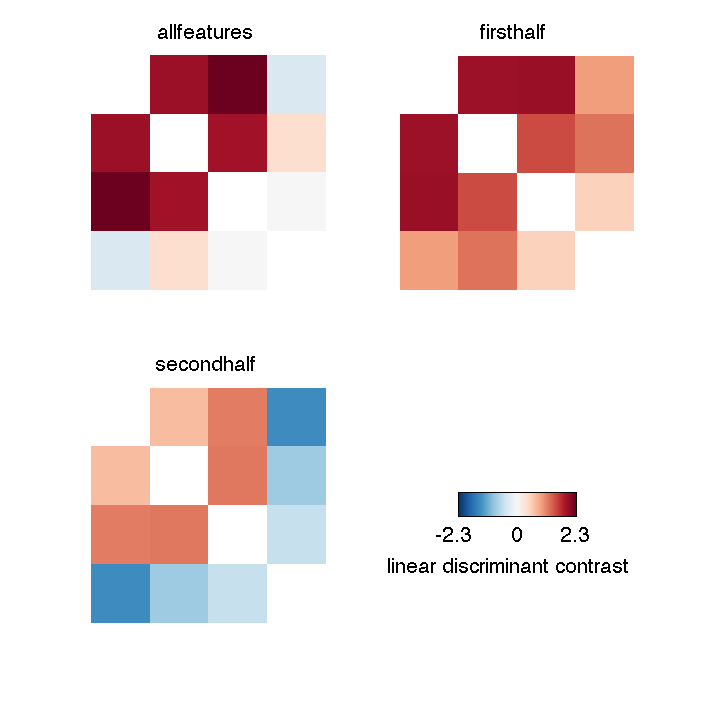

In [6]:
%plot -s 700,700 -r 300 -f svg
fh = gcf;
% round to 1 decimal place
maxd = reduceprecision(max(abs(disvol.data(:))),1);
[fh,ax,intmap,cmap] = rdmfig(disvol.data,disvol.meta.features.names,[],fh,...
    'limits',[-maxd maxd]);
cbax = subplot(2,2,4);
c = colorbarbetter(cbax,intmap{end},cmap{end},'label','linear discriminant contrast','scale',.5);

### What about linear discriminant T statistics?
The first papers to use something like LDC tended to report a related but distinct metric - a linear discriminant T statistic or LDT ([Kriegeskorte et al. 2007, PNAS](http://dx.doi.org/10.1073/pnas.0705654104)). In a way it's unfortunate that this method appeared first because it is more complex to calculate and understand than LDC. Let's return to the example to understand how it differs. To start with, here is the high level pilab implementation for reference:



In [7]:
% to get from infoc to infot, just call a different GLM class method
t = infot(model(2),discriminant(model(1),[1 -1 0 0]),[1 -1 0 0])

t =
    4.9786


The first thing to note is that the calculation of the weights vector remains similar to standard LDA, just like with LDC. However, whereas in LDC the test statistic is estimated by projecting the contrast estimate onto the discriminant dimension (ie, the weights vector), for LDT this won't do the job since we need an estimate of the *variance* of the discriminant to calculate T. Instead, we're going to project the full time courses onto the discriminant, like so:

In [8]:
% we go from one feature per voxel to one feature per discriminant
disctime = model(2).data * w1';

It took me a long time to work out the consequences of doing this. Let's visualise what the discriminant time courses look like to help guide our intuition.

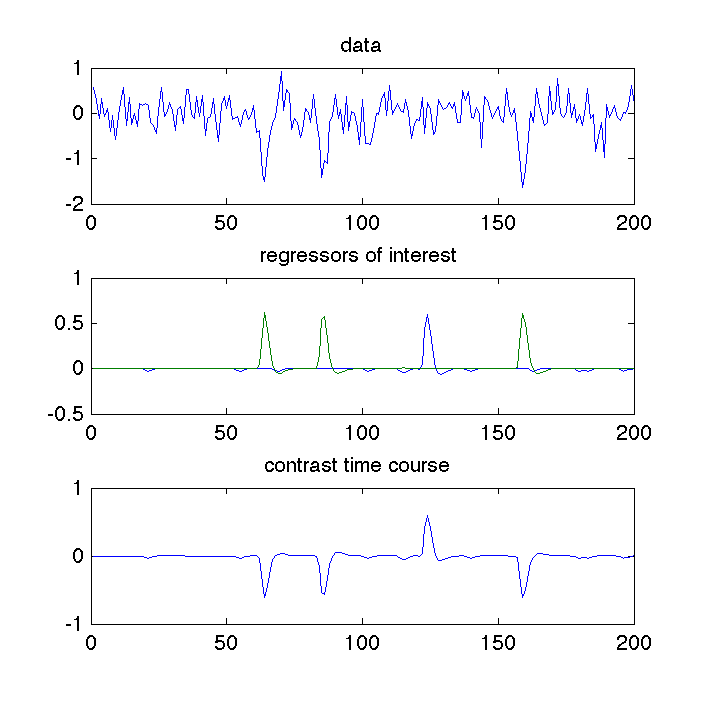

In [9]:
%plot -s 700,700 -r 300 -f svg
subplot(3,1,1);
plot(disctime);
title('data');
subplot(3,1,2);
plot(model(2).X(:,1:2));
title('regressors of interest');
subplot(3,1,3);
plot(model(2).X(:,1:2) * [1 -1]');
title('contrast time course');

Notice how the discriminant goes up whenever a stimulus belonging to condition 1 appears, and down whenever a stimulus belonging to condition 2 appears. Indeed, the discriminant time course looks a lot like the time course you get if you contrast the two predicted time courses. 

So now that we have a discriminant time course we can just fit it to the design matrix and estimate the same contrast that went into the calculation of the weights vector. And once we have that, standard errors and T statistics can be calculated like any multiple regression model. Neat. I won't belabour the point by coding out the full T statistic code, but basically we just build a new GLM instance and estimate contrasts and t statistics just like with any other model.

By the way, what do you think that discriminant time course contrast estimate looks like?

In [10]:
% parameter estimates for the test design matrix fitted to the discriminant time course
discest = model(2).X \ disctime;
% contrast estimate
disccon = [1 -1 0 0] * discest

disccon =
    2.0239


That's right, it's the LDC again. The dot-product-of-the-contrast approach above is an equivalent (and more computationally efficient) way to arrive at the same result. But by going about it in this roundabout way we have shown that LDC and LDT really differ only in whether you scale by the standard error estimate or not.

### Why is LDC preferable to LDT?
The appealing thing about LDT is that because it is expressed in standard error units, it provides a somewhat intuitive idea about effect size (well, technically we might prefer *LDZ* instead to avoid the dependence on degrees of freedom, but to my knowledge no one has reported using this). But this interpretability advantage breaks down when you consider cross-validation. If you run standard N-fold validation over say 5 runs, you will end up with 5 separate LDTs that you will average. That average is no longer a T statistic, and in fact you now run the risk of confusing your readers by reporting tiny, tiny 'T' statistics that are nevertheless highly significant. In my view, LDT is best suited to cases where you only plan to test your model on a single validation set, once.

That's it for today. Stay tuned for future posts, where we will cover how pilab implements non-parametric statistical inference and random effects group analysis for RSA and standard univariate models.